In [1]:
import logging
logging.basicConfig(
#         filename='file1.log',
        level=logging.WARNING,
        format='%(asctime)s %(levelname)s:\t%(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')

In [2]:
import re
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm_notebook
import sys
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from datetime import datetime
from lxml import etree, html as lhtml
import pandas as pd

# 1 этап. Нахождение ссылок на людей.

In [3]:
actors_links_txt = 'actors_links.txt'
popular_main_page = 'https://www.kinopoisk.ru/popular/names/day/2020-06-12/'
site_name = 'https://www.kinopoisk.ru'

attempts_number = 2

In [135]:
def process_one_author_books(popular_main_page, site_name, f_write):
    def find_the_number_of_iterations(author_soup):
        total_pages = 50
        total_actors = 10000
        return total_pages, total_actors
    def process_main_page(author_soup, curr_address):        
        r_get = requests.get(curr_address)
        tree = lhtml.fromstring(r_get.text)
        table_el = tree.xpath('//div[@class="stat js-rum-hero"]')
        lst_el = table_el[0].xpath('//a[@style="font:100 12px arial,sans-serif"]/attribute::href')
        if books_descs is None:
            logging.error('no books found:\t{}'.format(curr_address))
            return
        for it in lst_el:
            print(site_name + it, file=f_write)
        logging.info('success:\t\t{}'.format(curr_address))  
    def process_fork_page(curr_address):
        for i in range(1, attempts_number+1):
            r_get = requests.get(curr_address)
            if (r_get.ok):
                break
            logging.error('bad get request ({}/{}):\t{}'.format(i, attempts_number, curr_address))
            time.sleep(1)
        if not (r_get.ok):
            return
        author_soup = BeautifulSoup(r_get.text, 'lxml')
        process_main_page(author_soup, curr_address)

    for i in range(1, attempts_number+1):
        r_get = requests.get(popular_main_page)
        if (r_get.ok):
            break
        logging.error('bad get request ({}/{}):\t{}'.format(i, attempts_number, popular_main_page))
        time.sleep(1)
    if not (r_get.ok):
        return
    
    author_soup = BeautifulSoup(r_get.text, 'lxml')   
    total_pages, _ = find_the_number_of_iterations(author_soup)
    pages = []
    for curr_page in range(2, total_pages+1):
        pages.append(popular_main_page + 'page/{}/'.format(str(curr_page)))    
#     with ThreadPool(processes=total_pages) as pool:
#         pool.map(process_fork_page, pages)
    process_main_page(author_soup, popular_main_page)
    for page in pages:
        process_fork_page(page)

In [133]:
with open(actors_links_txt, 'w') as f_write:
    process_one_author_books(popular_main_page, site_name, f_write)
logging.info('completed')        

# 2 этап. Обкачка этих ссылок.

In [3]:
from selenium import webdriver

import random
import html
from time import sleep
from selenium.common.exceptions import NoSuchElementException        

In [4]:
def process_one_page(card_data):
    def check_exists_by_xpath(xpath, driver):
        try:
            driver.find_element_by_xpath(xpath)
        except NoSuchElementException:
            return False
        return True
    def find_name(driver, f_write):
        name = driver.find_element_by_xpath('//h1[@class="moviename-big"]').text
        print('\t{}'.format(name), file=f_write, end='')
    def find_favors(driver, f_write):
        favors = driver.find_element_by_xpath('//div[@class="num"]').text
        if favors != '':
            favors = int(favors)
        print('\t{}'.format(favors), file=f_write, end='')
    def find_foldrs(driver, f_write):
        foldrs = re.search(r'[0-9]+', driver.find_element_by_xpath('//div[@class="text"]').text)
        if foldrs is not None:
            foldrs = int(foldrs[0])
        print('\t{}'.format(foldrs), file=f_write, end='')
    def find_awards(driver, f_write):
        awards = check_exists_by_xpath('//table[@id="awardsBlock"]', driver)
        print('\t{}'.format(awards), file=f_write, end='')
    def find_best_oscar(driver, f_write):
        path1 = '//div[@class="awardsLargeBlockP Oscar best_serial"]'
        path2 = '//div[@class="awardsLargeBlockP Oscar best_serial"]//span[@class="num"]'
        best_oscar = 0
        if check_exists_by_xpath(path1, driver):
            best_oscar = 1
            if check_exists_by_xpath(path2, driver):
                best_oscar = driver.find_element_by_xpath(path2).text
        print('\t{}'.format(best_oscar), file=f_write, end='')
    def find_not_best_oscar(driver, f_write):
        path1 = '//div[@class="awardsLargeBlockP Oscar notbest_serial"]'
        path2 = '//div[@class="awardsLargeBlockP Oscar notbest_serial"]//span[@class="num"]'
        not_best_oscar = 0
        if check_exists_by_xpath(path1, driver):   
            not_best_oscar = 1
            if check_exists_by_xpath(path2, driver):
                not_best_oscar = driver.find_element_by_xpath(path2).text
        print('\t{}'.format(not_best_oscar), file=f_write, end='')
    def find_rating(driver, f_write):
        path = '//i[@id="avg_rating"]'
        rating = ''
        if check_exists_by_xpath(path, driver):
            rating = driver.find_element_by_xpath(path).text
        print('\t{}'.format(rating), file=f_write, end='')
    def find_screenwriter(driver, f_write):
        path = '//div[@id="writer"]//span[@class="viewingCount"]'
        writer = 0
        if check_exists_by_xpath(path, driver):
            writer = driver.find_element_by_xpath(path).text[1:-1]
            if writer == '':
                writer = 1
        print('\t{}'.format(writer), file=f_write, end='')
    def find_producer(driver, f_write):
        path = '//div[@id="producer"]//span[@class="viewingCount"]'
        producer = 0
        if check_exists_by_xpath(path, driver):
            producer = driver.find_element_by_xpath(path).text[1:-1]
            if producer == '':
                producer = 1
        print('\t{}'.format(producer), file=f_write, end='')
    def find_director(driver, f_write):
        path = '//div[@id="director"]//span[@class="viewingCount"]'
        director = 0
        if check_exists_by_xpath(path, driver):
            director = driver.find_element_by_xpath(path).text[1:-1]
            if director == '':
                director = 1
        print('\t{}'.format(director), file=f_write, end='')
    def find_editor(driver, f_write):
        path = '//div[@id="editor"]//span[@class="viewingCount"]'
        editor = 0
        if check_exists_by_xpath(path, driver):   
            editor = driver.find_element_by_xpath(path).text[1:-1]
            if editor == '':
                editor = 1
        print('\t{}'.format(editor), file=f_write, end='')
    def find_actor(driver, f_write):
        path = '//div[@id="actor"]//span[@class="viewingCount"]'
        actor = 0
        if check_exists_by_xpath(path, driver):   
            actor = driver.find_element_by_xpath(path).text[1:-1]
            if actor == '':
                actor = 1
        print('\t{}'.format(actor), file=f_write, end='')
    def process_describe_field(driver, f_write):
        describe = (e.text for e in driver.find_elements_by_xpath('//table[@class="info"]//tr'))
        describe = list(filter(None, map(str.lower, describe)))  
        fields = ['male', 'career', 'length', 'day', 'mounth', 'year', 'dth_day', 'dth_mounth', 'dth_year', \
                  'city', 'cntr_1', 'cntr_2', 'dth_city', 'dth_cntr_1', 'dth_cntr_2', \
                  'genres', 'chldrns', 'spouses', 'films_number', 'career_start', 'career_finish']
        d_fields = dict()
        for f in fields:
            d_fields[f] = ''
        for item in describe: 
            if item[:7] == 'карьера':
                d_fields['career'] = item[8:].replace(', ', ';').replace(',', ';')
                if re.search('(А|а)ктриса', d_fields['career']) is not None:
                    d_fields['male'] = 0
                elif re.search('(А|а)кт(е|ё)р', d_fields['career']) is not None:
                    d_fields['male'] = 1
            elif item[:4] == 'рост':
                d_fields['length'] = float(item[5:-2]) 
            elif item[:13] == 'дата рождения':
                b_day = item[14:].split(sep=',') 
                if len(b_day) != 2:
                    continue
                d_fields['day'] = int(b_day[0].split()[0])
                d_fields['mounth']  = b_day[0].split()[1]
                d_fields['year'] = int(re.search(r'[0-9]{4,}', b_day[1])[0])
            elif item[:11] == 'дата смерти':
                b_day = item[12:].split(sep=',') 
                if len(b_day) != 2:
                    continue
                d_fields['dth_day'] = int(b_day[0].split()[0])
                d_fields['dth_mounth']  = b_day[0].split()[1]
                d_fields['dth_year'] = int(re.search(r'[0-9]{4,}', b_day[1])[0])
            elif item[:14] == 'место рождения':
                b_place = item[15:].split(sep=',')
                d_fields['city'] = b_place[0]
                if len(b_place) != 1:
                    d_fields['cntr_1'] = b_place[1][1:]
                    if len(b_place) != 2:
                        d_fields['cntr_2'] = b_place[2][1:]
            elif item[:12] == 'место смерти':
                b_place = item[13:].split(sep=',')
                d_fields['dth_city'] = b_place[0]
                if len(b_place) != 1:
                    d_fields['dth_cntr_1'] = b_place[1][1:]
                    if len(b_place) != 2:
                        d_fields['dth_cntr_2'] = b_place[2][1:]
            elif item[:5] == 'жанры':
                d_fields['genres'] = ';'.join([i[1:] for i in item[5:].split(sep=',')])
            elif item[:7] == 'супруга':
                if d_fields['male'] != 0:
                    d_fields['male'] = 1
                family = item[8:].split(sep='\n')
                d_fields['chldrns'] = ';'.join([re.search(r'\.\.\. .*(ребен|детей)', i)[0][4:-6] for i in family \
                                     if re.search(r'\.\.\. .*(ребен|детей)', i) is not None])
                d_fields['spouses'] = ';'.join([i for i in family \
                                                if re.search(r'\.\.\. .*(ребен|детей)', i) is None])
            elif item[:6] == 'супруг':
                if d_fields['male'] != 1:
                    d_fields['male'] = 0
                family = item[7:].split(sep='\n')
                d_fields['chldrns'] = ';'.join([re.search(r'\.\.\. .*(ребен|детей)', i)[0][4:-6] for i in family \
                                     if re.search(r'\.\.\. .*(ребен|детей)', i) is not None])
                d_fields['spouses'] = ';'.join([i for i in family \
                                                if re.search(r'\.\.\. .*(ребен|детей)', i) is None])
            elif item[:13] == 'всего фильмов':
                total_films = item[14:].split(sep=',')
                d_fields['films_number'] = int(total_films[0])
                career_years = total_films[1][1:].split(sep=' — ')
                d_fields['career_start'] = int(career_years[0])
                if len(career_years) != 1:                
                    d_fields['career_finish'] = int(career_years[1])
        for f in fields:
            print('\t{}'.format(d_fields[f]), file=f_write, end='')
        
    url, driver, f_write, rank = card_data
    driver.get(url)      
    sleep(random.randint(2,20))

    print('{}'.format(rank), file=f_write, end='')
    find_name(driver, f_write)
    find_favors(driver, f_write)
    find_foldrs(driver, f_write)
    find_awards(driver, f_write)
    find_best_oscar(driver, f_write)
    find_not_best_oscar(driver, f_write)
    find_rating(driver, f_write)
    find_screenwriter(driver, f_write)
    find_producer(driver, f_write)
    find_director(driver, f_write)
    find_editor(driver, f_write)
    find_actor(driver, f_write)
    
    process_describe_field(driver, f_write)

    print('', file=f_write)
    logging.info('success:\t\t{}'.format(url))  

In [5]:
nrun = 31
start = 901
finish = 1001

def count_lines(filename):
    with open(filename) as file:
        return sum(chunk.count('\n') for chunk in iter(lambda: file.read(), ''))

cart_table_txt = 'cart_table({}).txt'.format(nrun)
actors_links_txt = 'actors_links_ranked.txt'
total_actors = count_lines(actors_links_txt)

In [6]:
pbar = tqdm_notebook(total=total_actors)
pbar.update(start)

with webdriver.Firefox() as driver:
    with open(cart_table_txt, 'w') as f_write:
        print('rank\tname\tfavors\tfolders\tawards\toscar\tnom_oscar\trating' +\
              '\twriter\tproducer\tdirector\teditor\tactor' +\
              '\tmale\tcareer\theight\tday\tmounth\tyear\tdth_day\tdth_mounth\tdth_year' +\
              '\tcity\tcntr_1\tcntr_2\tdth_city\tdth_cntr_1\tdth_cntr_2' +\
              '\tgenres\tchldrns\tspouses\ttotal_films\tcareer_start\tcaree_finish', file=f_write)
        card_tuples = []
        with open(actors_links_txt, 'r') as f_read:
            for rank, item in enumerate(f_read):
                card_tuples.append((item[:-2], driver, f_write, rank+1))
        
        for card_data in card_tuples[start:finish]:
            process_one_page(card_data)
            pbar.update(1)

In [7]:
little_df = pd.read_csv('cart_table({}).txt'.format(nrun), sep='\t')
total_df = pd.read_csv('total_cart_table({})'.format(nrun-1), sep='\t')
total_df = pd.concat([total_df, little_df])
total_df.to_csv('total_cart_table({})'.format(nrun), sep='\t', index=False)

# 3. DataMining

In [634]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import datetime as dt
# import csv

In [765]:
nrun = 37
# name = 'cart_table({}).txt'.format(nrun)
name = 'total_cart_table({})'.format(nrun)
df = pd.read_csv(name, sep='\t')
# df.head(2)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  print(df)

      rank                           name   favors   folders  awards  oscar  \
0        1                 Михаил Ефремов    695.0      4712   False    0.0   
1        2                       Гай Ричи   5358.0     39893    True    0.0   
2        3               Мэттью МакКонахи  16535.0     56727    True    1.0   
3        4              Квентин Тарантино  13997.0     73707    True    2.0   
4        5              Леонардо ДиКаприо  38557.0    128848    True    1.0   
5        6                      Том Харди  18927.0     69975    True    0.0   
6        7                Кристофер Нолан  10270.0   59285.0    True    0.0   
7        8             Александра Власова     87.0     489.0   False    0.0   
8        9                      Майкл Шин    881.0    6952.0    True    0.0   
9       10                   Уэс Андерсон   3918.0   19335.0    True    0.0   
10      11              Дженнифер Энистон   9497.0   47174.0    True    0.0   
11      12                  Дэвид Теннант   3896.0  

In [766]:
df.describe()

,rank,favors,oscar,nom_oscar,rating,writer,producer,director,editor,actor,male,height,day,year,dth_day,dth_year,total_films,career_start,caree_finish
count,2201.000000,2186.000000,2201.000000,2201.000000,2129.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2165.000000,1909.000000,2155.000000,2155.000000,172.000000,172.000000,2198.000000,2198.000000,2181.000000
mean,1101.000000,1080.293687,0.165834,0.063607,6.778206,3.523853,4.770559,3.649705,0.352113,49.893230,0.591224,1.748518,15.712297,1970.628306,16.569767,2000.046512,95.981347,1989.484986,2018.552957
std,635.518292,2435.503070,0.561034,0.669835,0.501496,11.711125,18.885049,10.268153,2.486337,42.609207,0.491721,0.098161,8.858834,19.629215,9.164565,22.120566,87.171740,17.838360,5.865821
min,1.000000,1.000000,0.000000,0.000000,2.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.070000,1.000000,1775.000000,1.000000,1817.000000,1.000000,1914.000000,1949.000000
25%,551.000000,127.000000,0.000000,0.000000,6.520000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,1.680000,8.000000,1961.000000,8.000000,1992.750000,37.000000,1980.000000,2019.000000
50%,1101.000000,353.000000,0.000000,0.000000,6.830000,0.000000,1.000000,0.000000,0.000000,42.000000,1.000000,1.750000,16.000000,1974.000000,17.000000,2007.000000,75.000000,1992.000000,2020.000000
75%,1651.000000,939.750000,0.000000,0.000000,7.080000,2.000000,4.000000,2.000000,0.000000,70.000000,1.000000,1.820000,23.000000,1985.000000,25.000000,2014.000000,130.000000,2003.000000,2020.000000
max,2201.000000,38557.000000,8.000000,26.000000,8.350000,278.000000,662.000000,128.000000,62.000000,498.000000,1.000000,2.010000,31.000000,2010.000000,31.000000,2020.000000,1004.000000,2021.000000,2027.000000


In [767]:
def fit_mounth(x):
    if x == 'января':
        return 1
    elif x == 'февраля':
        return 2
    elif x == 'марта':
        return 3
    elif x == 'апреля':
        return 4
    elif x == 'мая':
        return 5
    elif x == 'июня':
        return 6
    elif x == 'июля':
        return 7
    elif x == 'августа':
        return 8
    elif x == 'сентября':
        return 9
    elif x == 'октября':
        return 10
    elif x == 'ноября':
        return 11
    elif x == 'декабря':
        return 12
    else:
        return 
    
def find_zodiac(data):
    x = data % 10000
    if (321 <= x) and (x <= 420):
        return 'Aries'
    elif (421 <= x) and (x <= 520):
        return 'Taurus'
    elif (521 <= x) and (x <= 621):
        return 'Gemini'
    elif (622 <= x) and (x <= 722):
        return 'Cancer'
    elif (723 <= x) and (x <= 823):
        return 'Leo'
    elif (824 <= x) and (x <= 921):
        return 'Virgo'
    elif (922 <= x) and (x <= 1022):
        return 'Libra'
    elif (1023 <= x) and (x <= 1121):
        return 'Scorpio'
    elif (1122 <= x) and (x <= 1221):
        return 'Sagittarius'
    elif (1222 <= x) or (x <= 120):
        return 'Capricorn'
    elif (121 <= x) and (x <= 219):
        return 'Aquarius'
    elif (220 <= x) and (x <= 320):
        return 'Pisces'
    else:
        return 
    
def find_element(x):
    if x in {'Leo', 'Sagittarius', 'Aries'}:
        return 'fire'
    if x in {'Aquarius', 'Libra', 'Gemini'}:
        return 'air'
    if x in {'Scorpio', 'Cancer', 'Pisces'}:
        return 'water'
    if x in {'Taurus', 'Virgo', 'Capricorn'}:
        return 'earth'
    else:
        return 
    
zod_code = dict({
    'Aries': '1',
    'Taurus': '2',
    'Gemini': '3',
    'Cancer': '4',
    'Leo': '5',
    'Virgo': '6',
    'Libra': '7',
    'Scorpio': '8',
    'Sagittarius': '9',
    'Capricorn': '10',
    'Aquarius': '11',
    'Pisces': '12',
})

elem_color = dict({
    'fire': 'indianred',
    'air': 'lightgrey',
    'water': 'royalblue',
    'earth': 'olivedrab',
})

zod_color = dict({
    'Aries': 'brown',
    'Taurus': 'goldenrod',
    'Gemini': 'gainsboro',
    'Cancer': 'darkblue',
    'Leo': 'darkred',
    'Virgo': 'goldenrod',
    'Libra': 'lightgrey',
    'Scorpio': 'midnightblue',
    'Sagittarius': 'firebrick',
    'Capricorn': 'peru',
    'Aquarius': 'silver',
    'Pisces': 'navy',
})

In [768]:
df.loc[:, 'new_mounth'] = df['mounth'].map(fit_mounth)
df.dropna(subset=['new_mounth'], inplace=True)
df['new_mounth'] = df['new_mounth'].astype(int)
df['year'] = df['year'].astype(int)
df['day'] = df['day'].astype(int)
df['data'] = df['year']*10000 + df['new_mounth']*100 + df['day']
df['data'] = df['year']*10000 + df['new_mounth']*100 + df['day']
df.loc[:, 'zodiac'] = df['data'].map(find_zodiac)
df.loc[:, 'element'] = df['zodiac'].map(find_element)
df.head(2)

,rank,name,favors,folders,awards,oscar,nom_oscar,rating,writer,producer,...,genres,chldrns,spouses,total_films,career_start,caree_finish,new_mounth,data,zodiac,element
0,1,Михаил Ефремов,695.0,4712,False,0.0,0.0,6.08,1.0,0.0,...,комедия;драма;мелодрама,один;один;один;трое,ася воробьева (развод);евгения добровольская (...,195.0,1976.0,2020.0,11,19631110,Scorpio,water
1,2,Гай Ричи,5358.0,39893,True,0.0,0.0,7.68,13.0,7.0,...,короткометражка;криминал;боевик,двое;трое,мадонна (развод);джеки эйнсли,62.0,1995.0,2021.0,9,19680910,Virgo,earth


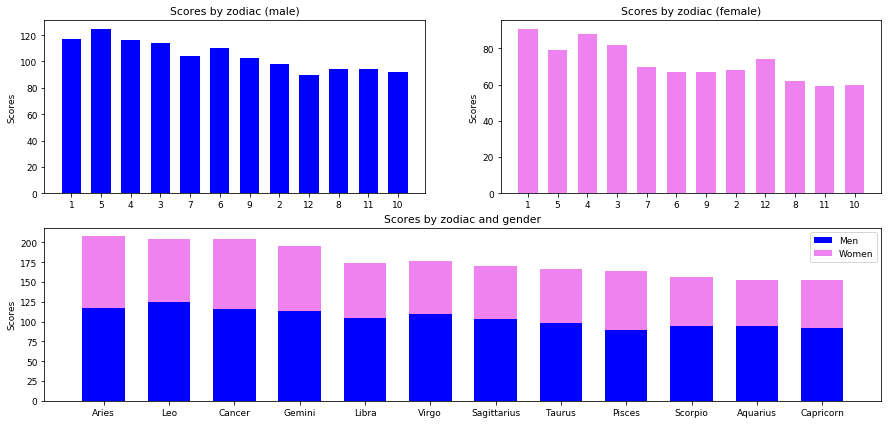

In [770]:
lft_tmp = df[df['male'] == 0]['zodiac'].value_counts()
rgt_tmp = df[df['male'] == 1]['zodiac'].value_counts()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df['zodiac'].value_counts()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('zodiac', ascending=False)

fig = plt.figure(figsize= (15,7))
ax1 = fig.add_subplot(221) 
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(212)
width = 0.65

ind = list(map(zod_code.get, temp_df.index))
means = temp_df['zodiac_y'].values
ax1.bar(ind, means, width, color='b')
ax1.set_ylabel('Scores')
ax1.set_title('Scores by zodiac (male)')

ind = list(map(zod_code.get, temp_df.index))
means = temp_df['zodiac_x'].values
ax2.bar(ind, means, width, color='violet')
ax2.set_ylabel('Scores')
ax2.set_title('Scores by zodiac (female)')

ind = temp_df['zodiac'].index
menMeans = temp_df['zodiac_y'].values
womMeans = temp_df['zodiac_x'].values
ax3.bar(ind, menMeans, width, color='b')
ax3.bar(ind, womMeans, width, bottom=menMeans, color='violet')
ax3.set_ylabel('Scores')
ax3.set_title('Scores by zodiac and gender')
# ax3.set_yticks(np.arange(0, 180, 20))
ax3.legend(labels=['Men', 'Women'])

plt.show()

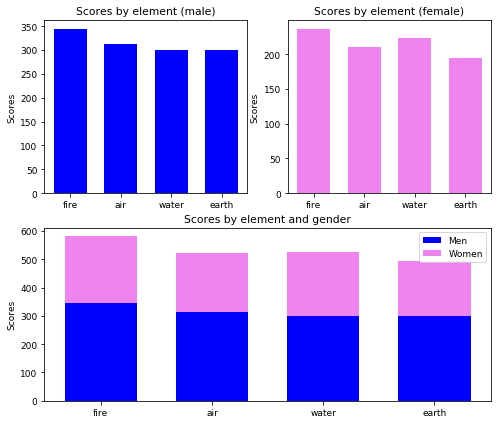

In [771]:
lft_tmp = df[df['male'] == 0]['element'].value_counts()
rgt_tmp = df[df['male'] == 1]['element'].value_counts()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df['element'].value_counts()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('element', ascending=False)

fig = plt.figure(figsize= (8,7))
ax1 = fig.add_subplot(221) 
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(212)
width = 0.65

ind = temp_df['element'].index
means = temp_df['element_y'].values
ax1.bar(ind, means, width, color='b')
ax1.set_ylabel('Scores')
ax1.set_title('Scores by element (male)')

ind = temp_df['element'].index
means = temp_df['element_x'].values
ax2.bar(ind, means, width, color='violet')
ax2.set_ylabel('Scores')
ax2.set_title('Scores by element (female)')

ind = temp_df['element'].index
menMeans = temp_df['element_y'].values
womMeans = temp_df['element_x'].values
ax3.bar(ind, menMeans, width, color='b')
ax3.bar(ind, womMeans, width, bottom=menMeans, color='violet')
ax3.set_ylabel('Scores')
ax3.set_title('Scores by element and gender')
# ax3.set_yticks(np.arange(0, 180, 20))
ax3.legend(labels=['Men', 'Women'])

plt.show()

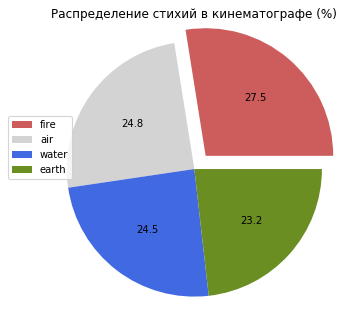

In [772]:
lft_tmp = df[df['male'] == 0]['element'].value_counts()
rgt_tmp = df[df['male'] == 1]['element'].value_counts()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df['element'].value_counts()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('element', ascending=False)

data_names = temp_df.index
data_values = temp_df.element

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Распределение стихий в кинематографе (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)],
    colors = list(map(elem_color.get, temp_df.index)),
    )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )

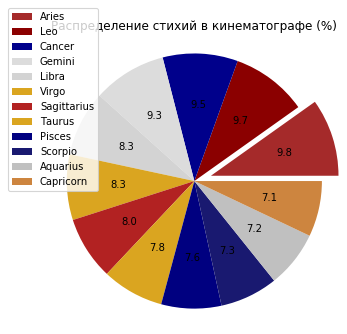

In [773]:
lft_tmp = df[df['male'] == 0]['zodiac'].value_counts()
rgt_tmp = df[df['male'] == 1]['zodiac'].value_counts()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df['zodiac'].value_counts()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('zodiac', ascending=False)

data_names = temp_df.index
data_values = temp_df.zodiac

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Распределение стихий в кинематографе (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)],
    colors = list(map(zod_color.get, temp_df.index)),
    )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )

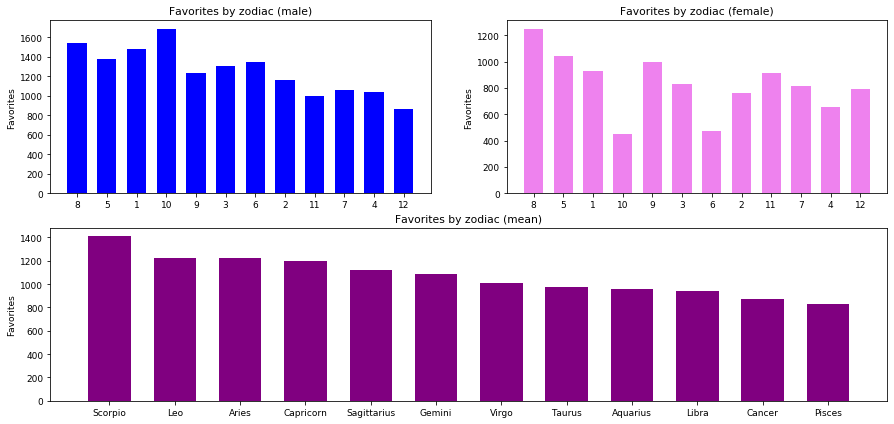

In [774]:
lft_tmp = df[df['male'] == 0].groupby(by=['zodiac'])['favors'].mean()
rgt_tmp = df[df['male'] == 1].groupby(by=['zodiac'])['favors'].mean()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df.groupby(by=['zodiac'])['favors'].mean()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('favors', ascending=False)

fig = plt.figure(figsize= (15,7))
ax1 = fig.add_subplot(221) 
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(212)
width = 0.65

ind = list(map(zod_code.get, temp_df.index))
means = temp_df['favors_y'].values
ax1.bar(ind, means, width, color='b')
ax1.set_ylabel('Favorites')
ax1.set_title('Favorites by zodiac (male)')

ind = list(map(zod_code.get, temp_df.index))
means = temp_df['favors_x'].values
ax2.bar(ind, means, width, color='violet')
ax2.set_ylabel('Favorites')
ax2.set_title('Favorites by zodiac (female)')

ind = temp_df['favors'].index
means = temp_df['favors'].values
ax3.bar(ind, means, width, color='purple')
ax3.set_ylabel('Favorites')
ax3.set_title('Favorites by zodiac (mean)')

plt.show()

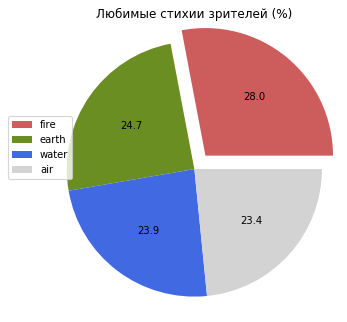

In [775]:
lft_tmp = df[df['male'] == 0].groupby(by=['element'])['favors'].mean()
rgt_tmp = df[df['male'] == 1].groupby(by=['element'])['favors'].mean()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df.groupby(by=['element'])['favors'].mean()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('favors', ascending=False)

data_names = temp_df.index
data_values = temp_df.favors

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Любимые стихии зрителей (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)],
    colors = list(map(elem_color.get, temp_df.index)),
    )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )

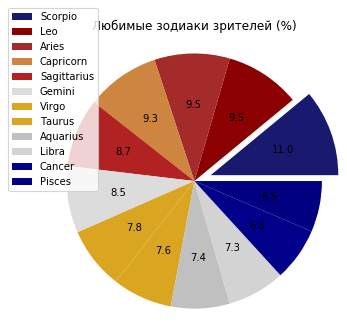

In [777]:
lft_tmp = df[df['male'] == 0].groupby(by=['zodiac'])['favors'].mean()
rgt_tmp = df[df['male'] == 1].groupby(by=['zodiac'])['favors'].mean()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df.groupby(by=['zodiac'])['favors'].mean()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('favors', ascending=False)

data_names = temp_df.index
data_values = temp_df.favors

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Любимые зодиаки зрителей (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)],
    colors = list(map(zod_color.get, temp_df.index)),
    )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )

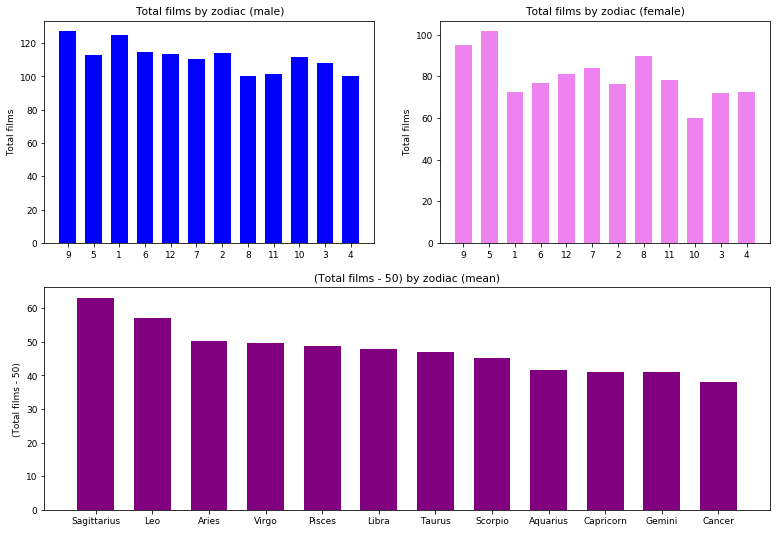

In [795]:
lft_tmp = df[df['male'] == 0].groupby(by=['zodiac'])['total_films'].mean()
rgt_tmp = df[df['male'] == 1].groupby(by=['zodiac'])['total_films'].mean()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df.groupby(by=['zodiac'])['total_films'].mean()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('total_films', ascending=False)

fig = plt.figure(figsize= (13,9))
ax1 = fig.add_subplot(221) 
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(212)
width = 0.65

ind = list(map(zod_code.get, temp_df.index))
means = temp_df['total_films_y'].values
ax1.bar(ind, means, width, color='b')
ax1.set_ylabel('Total films')
ax1.set_title('Total films by zodiac (male)')

ind = list(map(zod_code.get, temp_df.index))
means = temp_df['total_films_x'].values
ax2.bar(ind, means, width, color='violet')
ax2.set_ylabel('Total films')
ax2.set_title('Total films by zodiac (female)')

ind = temp_df['total_films'].index
means = temp_df['total_films'].values - 50
ax3.bar(ind, means, width, color='purple')
ax3.set_ylabel('(Total films - 50)')
ax3.set_title('(Total films - 50) by zodiac (mean)')
# ax3.set_yticks(np.arange(0, 10, 5))

plt.show()

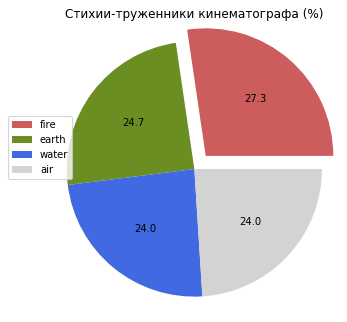

In [779]:
lft_tmp = df[df['male'] == 0].groupby(by=['element'])['total_films'].mean()
rgt_tmp = df[df['male'] == 1].groupby(by=['element'])['total_films'].mean()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df.groupby(by=['element'])['total_films'].mean()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('total_films', ascending=False)

data_names = temp_df.index
data_values = temp_df.total_films

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Стихии-труженники кинематографа (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)],
    colors = list(map(elem_color.get, temp_df.index)),
    )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )

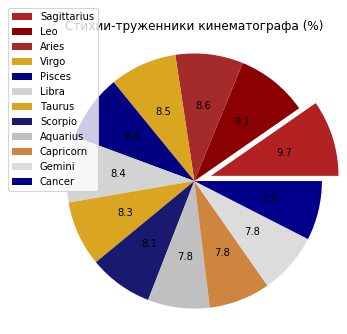

In [780]:
lft_tmp = df[df['male'] == 0].groupby(by=['zodiac'])['total_films'].mean()
rgt_tmp = df[df['male'] == 1].groupby(by=['zodiac'])['total_films'].mean()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df.groupby(by=['zodiac'])['total_films'].mean()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('total_films', ascending=False)

data_names = temp_df.index
data_values = temp_df.total_films

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Стихии-труженники кинематографа (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)],
    colors = list(map(zod_color.get, temp_df.index)),
    )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )

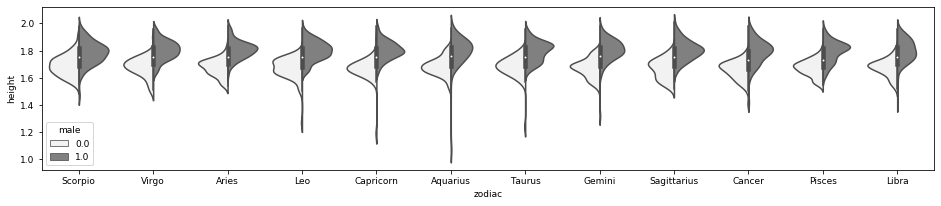

In [781]:
fig = plt.figure(figsize= (16,3))
sns.violinplot(y="height", x="zodiac", hue = 'male', split = True, data=df, color='grey')

In [782]:
df.groupby(by=['male'])['height'].mean()

male
0.0    1.674769
1.0    1.799739
Name: height, dtype: float64

In [783]:
df.year.mean()

1970.6283062645011

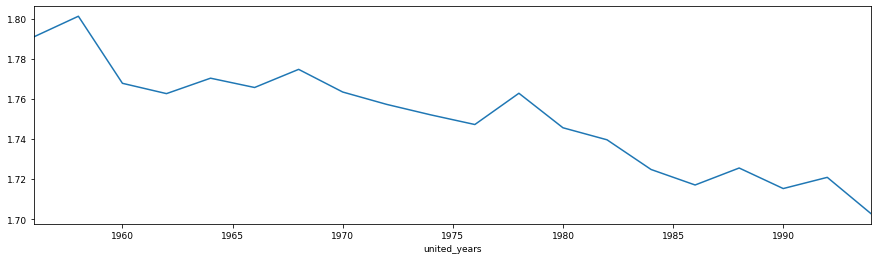

In [784]:
fig = plt.figure(figsize= (15,4))
temp_df = df
temp_df['united_years'] = temp_df['year'].map(lambda x: (x - x%2))
temp_df = temp_df[['united_years', 'height', 'male']].dropna()
# temp_df = temp_df[temp_df.male == 1]
temp_df = temp_df[temp_df.united_years >= 1955]
temp_df = temp_df[temp_df.united_years <= 1995]
temp_df.groupby(by=['united_years'])['height'].mean().plot.line() 

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


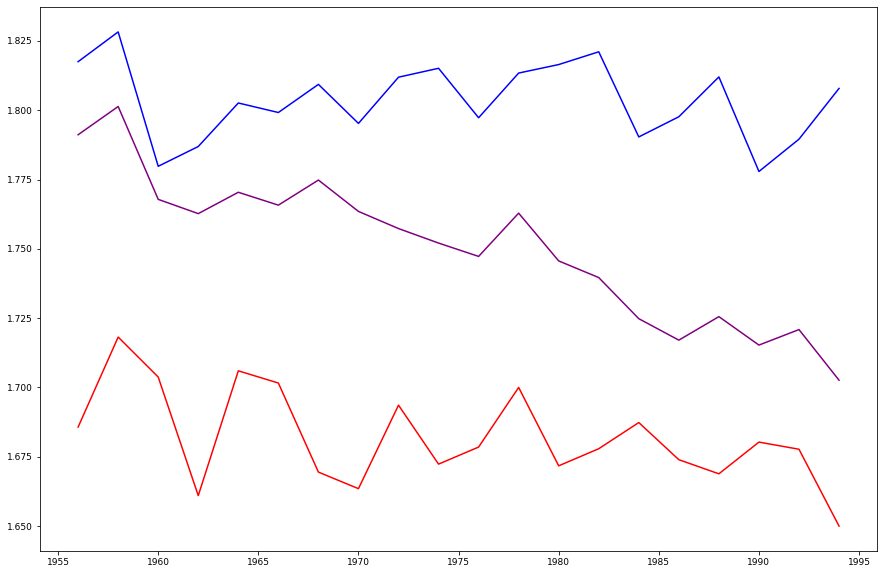

In [785]:
fig = plt.figure(figsize= (15,10))

x = temp_df.groupby(by=['united_years'])['united_years'].mean()
y = temp_df.groupby(by=['united_years'])['height'].mean()
plt.plot(x, y, 'purple') # plotting t, a separately 

x = temp_df[df.male == 1].groupby(by=['united_years'])['united_years'].mean()
y = temp_df[df.male == 1].groupby(by=['united_years'])['height'].mean()
plt.plot(x, y, 'b') # plotting t, b separately 

x = temp_df[df.male == 0].groupby(by=['united_years'])['united_years'].mean()
y = temp_df[df.male == 0].groupby(by=['united_years'])['height'].mean()
plt.plot(x, y, 'r') # plotting t, c separately 

plt.show()

In [786]:
df[df.male == 0][df.united_years <= 1955]['united_years'].value_counts().head()

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1934    9
1948    9
1944    7
1946    7
1954    6
Name: united_years, dtype: int64

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


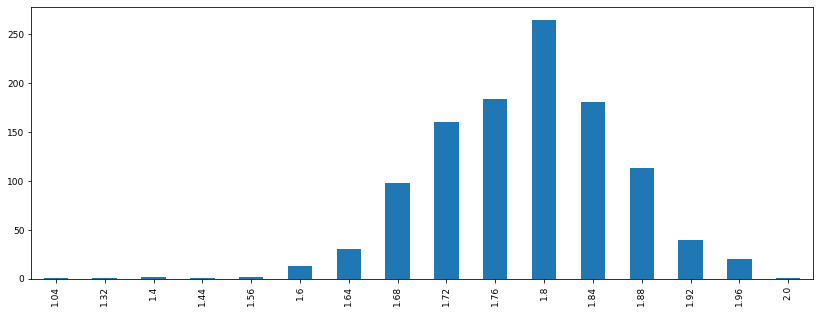

In [787]:
fig = plt.figure(figsize= (14,5))
# plt.legend(labels=['Men', 'Women'])
temp_df = df[df['male']==1]
temp_df['united_hght'] = temp_df['height'].map(lambda x: ((x*100) - (x*100) % 4)/100)
temp_df['united_hght'].value_counts().sort_index().plot.bar()

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


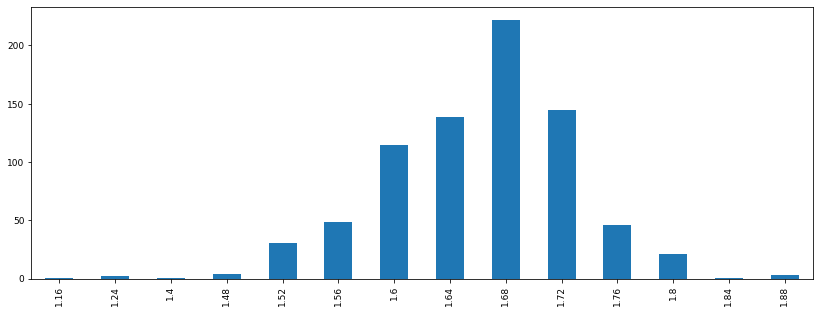

In [788]:
fig = plt.figure(figsize= (14,5))
temp_df = df[df['male']==0]
temp_df['join_hght'] = temp_df['height'].map(lambda x: ((x*100) - (x*100) % 4)/100)
temp_df['join_hght'].value_counts().sort_index().plot.bar()

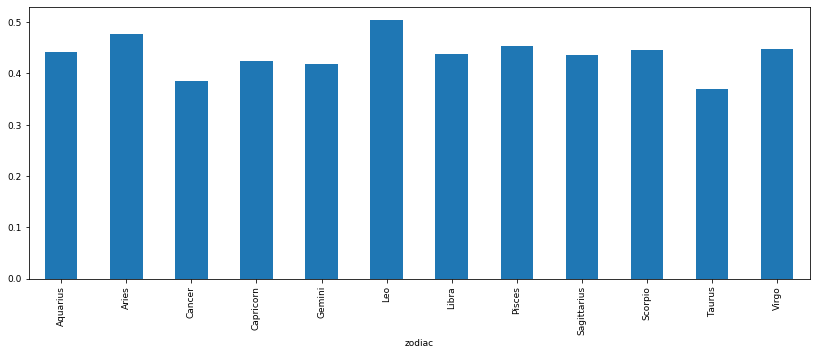

In [796]:
fig = plt.figure(figsize= (14,5))

df['awards'] = df['awards'].astype(bool).astype(int)
# (df.groupby(by=['zodiac'])['awards'].sum() / df.groupby(by=['zodiac'])['awards'].count()).plot.line()
(df.groupby(by=['zodiac'])['awards'].sum() / df.groupby(by=['zodiac'])['awards'].count() - 0.01).plot.bar()

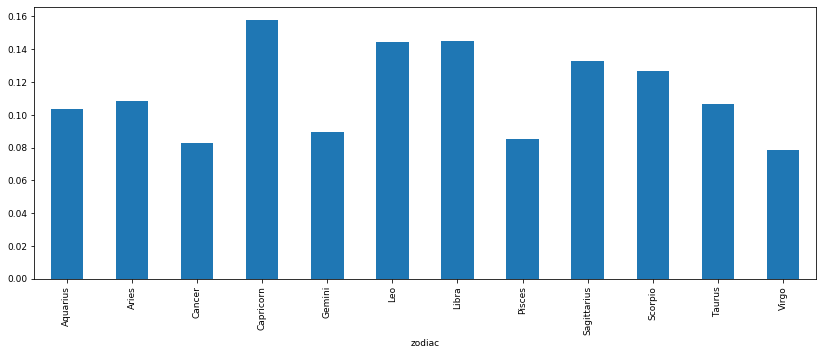

In [791]:
# топ победителей

fig = plt.figure(figsize= (14,5))
df['oscar'] = df['oscar'].astype(int)
df['have_oscar'] = df['oscar'].astype(bool).astype(int)
(df.groupby(by=['zodiac'])['have_oscar'].sum() / df.groupby(by=['zodiac'])['have_oscar'].count()).plot.bar()

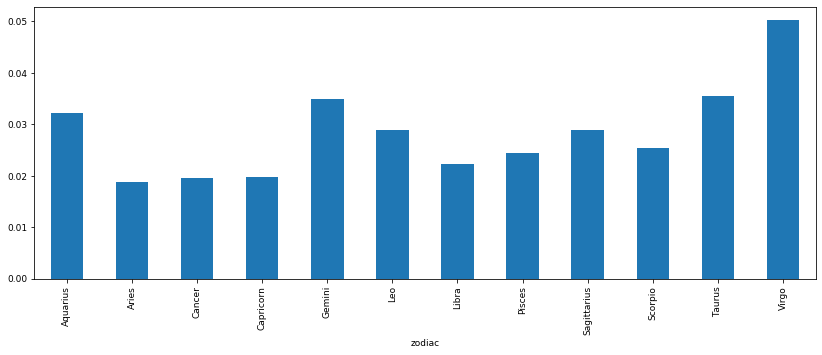

In [792]:
# топ неудачников

fig = plt.figure(figsize= (14,5))
df['nom_oscar'] = df['nom_oscar'].astype(int)
df['have_nom_oscar'] = df['nom_oscar'].astype(bool).astype(int)
(df.groupby(by=['zodiac'])['have_nom_oscar'].sum() / df.groupby(by=['zodiac'])\
     ['have_nom_oscar'].count()).plot.bar()

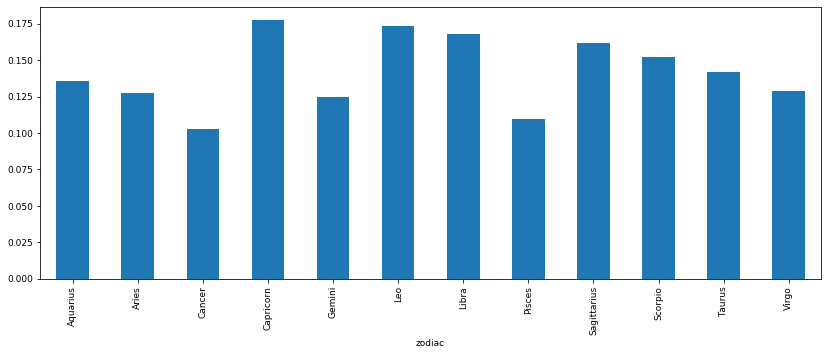

In [793]:
# топ номинирующихся+ на оскар

fig = plt.figure(figsize= (14,5))
df['have_oscar_or_nom_oscar'] = (df['nom_oscar'] + df['oscar']).astype(bool).astype(int)
(df.groupby(by=['zodiac'])['have_oscar_or_nom_oscar'].sum() / df.groupby(by=['zodiac'])\
    ['have_oscar_or_nom_oscar'].count()).plot.bar()

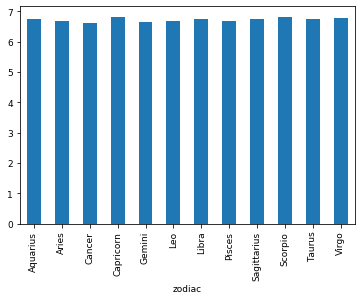

In [794]:
temp_df = df[df['male']==0]
temp_df.groupby(by=['zodiac'])['rating'].mean().plot.bar()

In [340]:
df['folders'] = df['folders'].astype(float)
df.groupby(by=['zodiac'])['folders'].mean().plot.bar()

ValueError: could not convert string to float: 'None'